# B, E, J
author: Louis Richard\
Plots of B, J, E, JxB electric field, and J.E. Calculates J using Curlometer method. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyrfu.mms import get_data
from pyrfu.plot import plot_line
from pyrfu.pyrf import (resample, avg_4sc, edb, c_4_j, norm, convert_fac, dot)

## Define time interval and spacecraft indices

In [2]:
tint = ["2016-06-07T10:00:00.000", "2016-06-07T12:00:00.000"]
ic = np.arange(1, 5)

## Load data

### Load background magnetic field (FGM)

In [4]:
b_mms = [get_data("b_dmpa_fgm_srvy_l2", tint, i) for i in ic]
b_mms = [resample(b_xyz, b_mms[0]) for b_xyz in b_mms]
b_xyz = avg_4sc(b_mms)

Loading mms1_fgm_b_dmpa_srvy_l2...
Loading mms2_fgm_b_dmpa_srvy_l2...
Loading mms3_fgm_b_dmpa_srvy_l2...
Loading mms4_fgm_b_dmpa_srvy_l2...


### Load electric field (EDP)

In [5]:
e_mms = [get_data("e2d_dsl_edp_fast_l2pre", tint, i) for i in ic]
e_mms = [resample(e_xyz, e_mms[0]) for e_xyz in e_mms]
e_xyz = avg_4sc(e_mms)

Loading mms1_edp_dce_dsl_fast_l2pre...
Loading mms2_edp_dce_dsl_fast_l2pre...
Loading mms3_edp_dce_dsl_fast_l2pre...
Loading mms4_edp_dce_dsl_fast_l2pre...


### Load ion number density (FPI)

In [6]:
n_mms_i = [get_data("Nhplus_hpca_srvy_l2", tint, i) for i in ic]
n_mms_i = [resample(n_i, n_mms_i[0]) for n_i in n_mms_i]

n_i = avg_4sc(n_mms_i)
n_i = resample(n_i, b_mms[0])

Loading mms1_hpca_hplus_number_density...
Loading mms2_hpca_hplus_number_density...
Loading mms3_hpca_hplus_number_density...
Loading mms4_hpca_hplus_number_density...


### Load spacecraft position (MEC)

In [7]:
r_mms = [get_data("R_gse", tint, i) for i in ic]

Loading mms1_mec_r_gse...
Loading mms2_mec_r_gse...
Loading mms3_mec_r_gse...
Loading mms4_mec_r_gse...


## Compute current density, Hall electric field and E.J

#### Compute current density using curlometer

In [8]:
j_xyz, div_b, _, jxb_xyz, _, _ = c_4_j(r_mms, b_mms)
div_over_curl = div_b.copy()
div_over_curl.data = abs(div_over_curl.data) / norm(j_xyz)

#### Transform current density into field-aligned coordinates

In [9]:
j_fac = convert_fac(j_xyz, b_xyz,[1, 0, 0])
j_xyz.data *= 1e9
j_fac.data *= 1e9

### Compute Hall electric field

In [10]:
jxb_xyz.data /= n_i.data[:, None]
jxb_xyz.data /= 1.6e-19 * 1000                   # Convert to (mV/m)
jxb_xyz.data[abs(jxb_xyz.data) > 100.] = np.nan  # Remove some questionable fields

### Compute E.J

In [11]:
j_xyz = resample(j_xyz, e_xyz)
e_dot_j = dot(e_xyz, j_xyz) / 1000  # J (nA/m^2), E (mV/m), E.J (nW/m^3)

## Plot figure

In [12]:
legend_options = dict(ncol=4, loc="upper right", frameon=True)

<IPython.core.display.Javascript object>


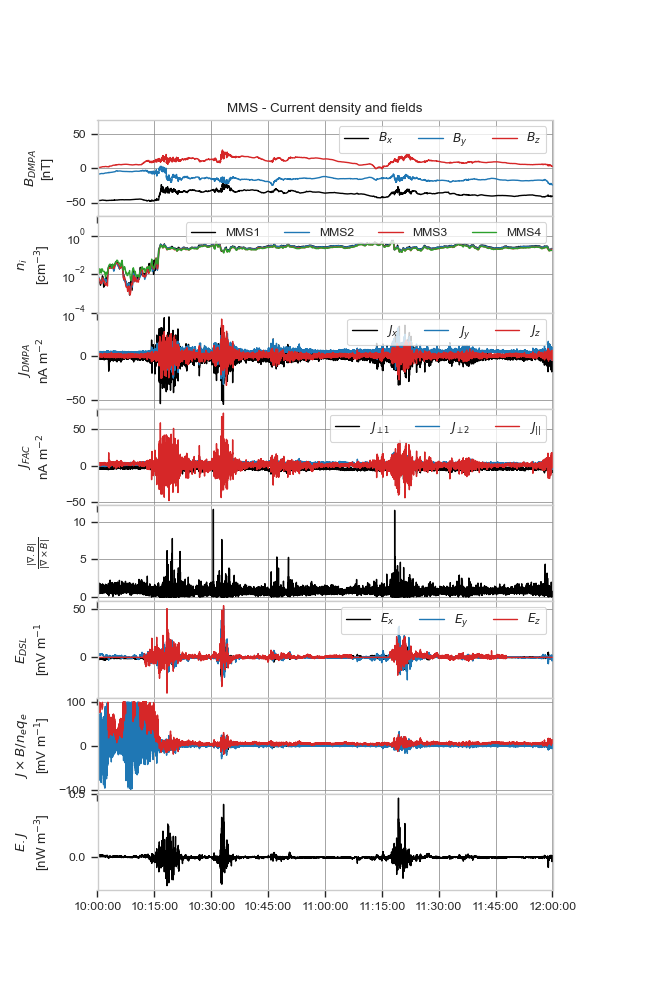

(736122.4166666666, 736122.5)

In [13]:
%matplotlib notebook
f, axs = plt.subplots(8, sharex="all", figsize=(6.5, 10))
f.subplots_adjust(hspace=0, left=.15, right=.85)
plot_line(axs[0], b_xyz)
axs[0].set_ylabel("$B_{DMPA}$" + "\n" + "[nT]")
axs[0].legend(["$B_{x}$","$B_{y}$","$B_{z}$"], **legend_options)
axs[0].set_ylim([-70, 70])

labels = []
for i, n in enumerate(n_mms_i):
    plot_line(axs[1], n)
    labels.append("MMS{:d}".format(i + 1))

axs[1].set_ylabel("$n_i$" + "\n" + "[cm$^{-3}$]")
axs[1].set_yscale("log")
axs[1].set_ylim([1e-4, 10])
axs[1].legend(labels, **legend_options)

plot_line(axs[2], j_xyz)
axs[2].set_ylabel("$J_{DMPA}$" + "\n" + "nA m$^{-2}$")
axs[2].legend(["$J_{x}$","$J_{y}$","$J_{z}$"], **legend_options)

plot_line(axs[3], j_fac)
axs[3].set_ylabel("$J_{FAC}$" + "\n" + "nA m$^{-2}$")
axs[3].legend(["$J_{\\perp 1}$","$J_{\\perp 2}$","$J_{||}$"], **legend_options)

plot_line(axs[4], div_over_curl)
axs[4].set_ylabel("$\\frac{|\\nabla . B|}{|\\nabla \\times B|}$")

plot_line(axs[5], e_xyz);
axs[5].set_ylabel("$E_{DSL}$" + "\n" +"[mV m$^{-1}$")
axs[5].legend(["$E_{x}$","$E_{y}$","$E_{z}$"], **legend_options)

plot_line(axs[6],jxb_xyz)
axs[6].set_ylabel("$J \\times B/n_{e} q_{e}$" + "\n" + "[mV m$^{-1}$]")

plot_line(axs[7], e_dot_j)
axs[7].set_ylabel("$E . J$" + "\n" +"[nW m$^{-3}$]")

axs[0].set_title("MMS - Current density and fields")

f.align_ylabels(axs)
axs[-1].set_xlim(tint)